In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

data = pd.read_csv('../data/updated_cleaned_patient_data.csv')

feature_cols = [
    'FBS', 'BMI', 'Diabetes', 'age', 'hypertension',
    'vegetarian (1= yes, 0=no)', 'Exercise (min/week)',
    'Cholesterol', 'Living_Area_Code', 'Marriage_Status_Code'
]

X = data[feature_cols].fillna(0)
y = data['stroke']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=102, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [51]:
# model = KNeighborsClassifier(n_neighbors=3, weights='uniform', p=1)
# p=1 หมายถึง Manhattan Distance (วัดระยะแบบเดินตามบล็อกตาราง หรือ ผลรวมค่าสัมบูรณ์)

# model = KNeighborsClassifier(n_neighbors=3, weights='uniform', p=2)
# p=2 หมายถึง Euclidean Distance (วัดระยะแบบลากเส้นตรงจุดต่อจุด หรือ สูตรพีทาโกรัส)

# model = KNeighborsClassifier(n_neighbors=3, metric='hamming')
# metric='hamming' หมายถึง Hamming Distance (เหมาะกับข้อมูลหมวดหมู่/Binary: วัดระยะโดยการนับจำนวนตำแหน่งที่ค่า "ไม่เหมือนกัน")

model = KNeighborsClassifier(n_neighbors=50,weights='distance', p=2)
model.fit(X_train_scaled, y_train)

,n_neighbors,50
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [52]:
train_pred = model.predict(X_train_scaled)
test_pred = model.predict(X_test_scaled)

print("Train Accuracy:", accuracy_score(y_train, train_pred))
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print(classification_report(y_test, test_pred))

Train Accuracy: 1.0
Test Accuracy: 0.775
              precision    recall  f1-score   support

           0       0.79      0.95      0.86       150
           1       0.62      0.26      0.37        50

    accuracy                           0.78       200
   macro avg       0.71      0.60      0.61       200
weighted avg       0.75      0.78      0.74       200



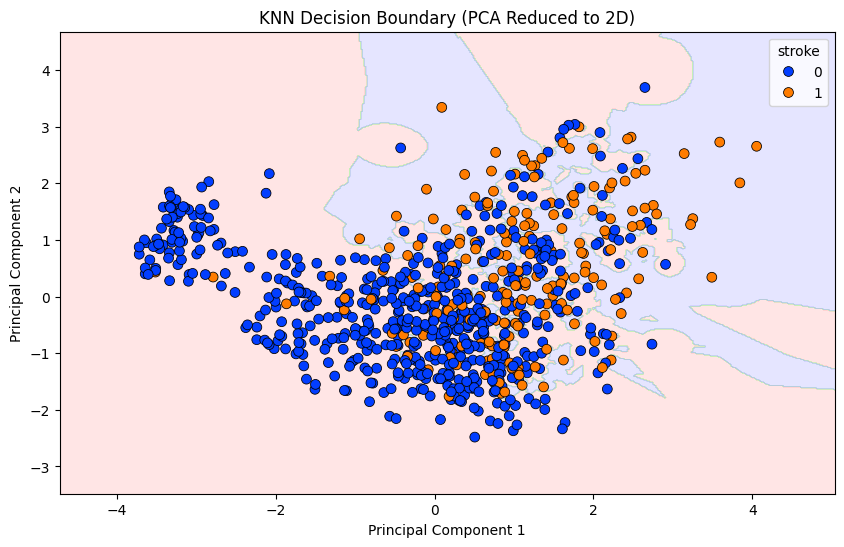

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

# --- ส่วนเตรียมข้อมูลสำหรับพล็อต (ลดมิติเหลือ 2D) ---
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# ต้องเทรนโมเดลใหม่ด้วยข้อมูล 2D เพื่อการวาดกราฟ (ใช้ setting เดิมของคุณ)
# *** อย่าลืมแก้ค่า n_neighbors, weights, p ให้ตรงกับที่คุณใช้อยู่ ***
clf_viz = KNeighborsClassifier(n_neighbors=3, weights='distance', p=2) 
clf_viz.fit(X_train_pca, y_train)

# --- ส่วนวาดกราฟ ---
h = .02  # ความละเอียดของ mesh step
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# ทำนายผลลงบนพื้นที่กราฟ
Z = clf_viz.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# วาดสีพื้นหลัง (Decision Boundary)
plt.figure(figsize=(10, 6))
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF']) # สีพื้นหลัง (แดง, เขียว, ฟ้าอ่อน)
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF']) # สีจุด (แดง, เขียว, น้ำเงินเข้ม)

plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.3)

# วาดจุดข้อมูลจริงลงไป (Scatter plot)
import seaborn as sns
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, 
                palette='bright', edgecolor='k', s=50)

plt.title("KNN Decision Boundary (PCA Reduced to 2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

<Figure size 800x600 with 0 Axes>

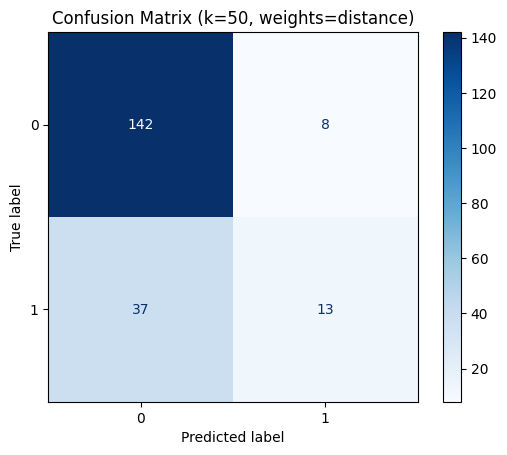

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 1. สร้างกราฟ
plt.figure(figsize=(8, 6))

# 2. พล็อต Confusion Matrix (ใช้โมเดลที่คุณเทรนเสร็จแล้ว)
# model: ตัวแปร model ที่ fit แล้ว
# X_test_scaled: ข้อมูลทดสอบ (ที่ scale แล้ว)
# y_test: เฉลยจริง
ConfusionMatrixDisplay.from_estimator(
    model, 
    X_test_scaled, 
    y_test, 
    cmap=plt.cm.Blues  # สีโทนฟ้า (เปลี่ยนเป็น plt.cm.Greens ได้)
)

plt.title(f"Confusion Matrix (k={model.n_neighbors}, weights={model.weights})")
plt.show()